# Projeto 14.2 - Rede Neural Convolucional Homer e Bart

## 1. Importando bibliotecas

In [58]:
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

torch.__version__

'2.5.0'

In [59]:
torch.set_default_device("mps")
device = torch.device("mps")

# torch.set_default_device("cpu")
# device = torch.device("cpu")

In [60]:
print(torch.backends.mps.is_available())  # Deve retornar True
print(torch.backends.mps.is_built())  # Deve retornar True

True
True


## 2. Importando dados

In [61]:
torch.manual_seed(123)

In [17]:
dataset = pd.read_csv("data/personagens.csv")

In [18]:
dataset.head()

,laranja_camisa_bart,azul_calcao_bart,azul_sapato_bart,marrom_boca_homer,azul_calca_homer,cinza_sapato_homer,classe
0,6.886102,3.495204,1.484984,0.000000,0.0,0.062954,Bart
1,5.004901,3.183889,1.000142,0.000000,0.0,0.033024,Bart
2,5.264620,5.029683,0.283567,0.000000,0.0,0.151573,Bart
3,0.000000,0.000000,0.000000,0.480168,0.0,0.021164,Bart
4,8.978929,3.459119,0.000000,0.000000,0.0,0.011593,Bart


In [19]:
preditores = dataset.drop(columns=["classe"])
classes = dataset["classe"]

In [20]:
encoder = LabelEncoder()
classes = encoder.fit_transform(classes)
classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [21]:
previsores_treino, previsores_teste, classe_treino, classe_teste = train_test_split(preditores, classes, test_size = 0.25)

In [22]:
previsores_treino = torch.tensor(np.array(previsores_treino), dtype=torch.float)
classe_treino = torch.tensor(classe_treino, dtype=torch.long)

In [24]:
train_dataset = torch.utils.data.TensorDataset(previsores_treino, classe_treino)

In [26]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=False,  # MPS não suporta pin_memory=True
                                                                              generator=torch.Generator(device=device))

## 3. Construção do modelo

In [27]:
previsores_treino.shape

torch.Size([219, 6])

In [35]:
# output = (input + output) / 2 = 6 + 1 / 2 = 3
# stride -> de quantos em quantos pixels é o janelamento para convolucao
classificador = nn.Sequential(
            nn.Linear(in_features=6, out_features=4),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=4, out_features=4),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=4, out_features=1),
            nn.Sigmoid()
)

In [36]:
criterion = nn.BCELoss()
optimizer = optim.Adam(classificador.parameters())

## 4. Treinamento do modelo

In [37]:
classificador.to(device)

Sequential(
  (0): Linear(in_features=6, out_features=4, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=4, out_features=4, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=4, out_features=1, bias=True)
  (7): Sigmoid()
)

In [40]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classificador(inputs)

        loss = criterion(outputs, labels.float().view(*outputs.shape))
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        predicted = torch.tensor([1 if output > 0.5 else 0 for output in outputs]).to(device)

        equals = predicted == labels.view(*predicted.shape)

        accuracy = torch.mean(equals.float())
        running_accuracy += accuracy

        # print('\rEpoch: {:4d} - Loop {:3d} of {:3d} - Loss: {:6.4f} - Accuracy: {:6.4f}'.format(epoch + 1,
        #               i + 1,
        #               len(loader),
        #               loss,                                                                          
        #               accuracy), end = '\r')

    print(f"\rEnded Epoch {epoch + 1} - loss: {running_loss/len(loader)} - precision: {running_accuracy/len(loader)}")

In [42]:
print("Training...")
for epoch in range(2000):
    training_loop(train_loader, epoch)

Training...
Ended Epoch 1 - loss: 0.1887403620140893 - precision: 0.9135251045227051
Ended Epoch 2 - loss: 0.21326032280921936 - precision: 0.8984788656234741
Ended Epoch 3 - loss: 0.20587744138070516 - precision: 0.8895502686500549
Ended Epoch 4 - loss: 0.19823699657406127 - precision: 0.8875661492347717
Ended Epoch 5 - loss: 0.2277792372873851 - precision: 0.8806217312812805
Ended Epoch 6 - loss: 0.19630594019378936 - precision: 0.8850859999656677
Ended Epoch 7 - loss: 0.17779307706015451 - precision: 0.9171627163887024
Ended Epoch 8 - loss: 0.20570145334516252 - precision: 0.8887234926223755
Ended Epoch 9 - loss: 0.1960341717515673 - precision: 0.9054232835769653
Ended Epoch 10 - loss: 0.20593854359218053 - precision: 0.8948412537574768
Ended Epoch 11 - loss: 0.22913633499826705 - precision: 0.89682537317276
Ended Epoch 12 - loss: 0.22113951402051107 - precision: 0.8948412537574768
Ended Epoch 13 - loss: 0.17126973931278502 - precision: 0.9241071343421936
Ended Epoch 14 - loss: 0.18

## 5. Avaliação do modelo

In [43]:
classificador.eval()

Sequential(
  (0): Linear(in_features=6, out_features=4, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=4, out_features=4, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=4, out_features=1, bias=True)
  (7): Sigmoid()
)

In [44]:
type(previsores_teste)

pandas.core.frame.DataFrame

In [45]:
previsores_teste = torch.tensor(np.array(previsores_teste), dtype=torch.float)

In [46]:
previsoes = classificador(previsores_teste)
previsoes

tensor([[0.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [8.1797e-01],
        [0.0000e+00],
        [7.5364e-01],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [2.2557e-01],
        [1.0000e+00],
        [6.6371e-11],
        [0.0000e+00],
        [2.7844e-01],
        [1.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [1.6559e-01],
        [1.0000e+00],
        [0.0000e+00],
        [2.4672e-01],
        [1.0000e+00],
        [1.0000e+00],
        [4.8332e-01],
        [9.9997e-01],
        [3.1592e-01],
        [0.0000e+00],
        [1.0000e+00],
        [2.5990e-01],
        [0.0000e+00],
        [3.3535e-01],
        [1.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [7

In [49]:
previsoes = np.array(previsoes.cpu() > 0.5)

/var/folders/rb/g2rznbp50d56w_26l6lfc72c0000gn/T/ipykernel_86514/319443599.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  previsoes = np.array(previsoes.cpu() > 0.5)


In [50]:
previsoes

array([[False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [

In [53]:
taxa_acerto = accuracy_score(classe_teste, previsoes)
taxa_acerto

0.8783783783783784

In [54]:
matriz = confusion_matrix(classe_teste, previsoes)
matriz

array([[37,  1],
       [ 8, 28]])

<Axes: >

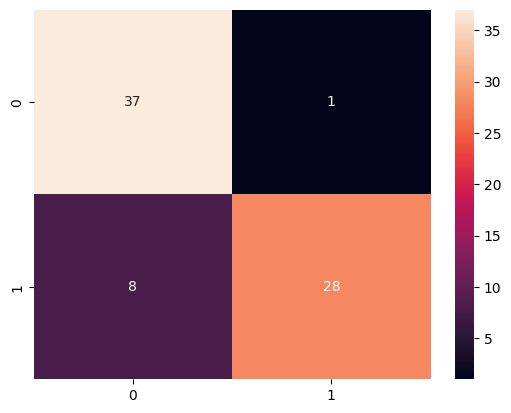

In [57]:
sns.heatmap(matriz, annot=True)